# Multirate DSP

Multirate signal processing is the study and implementation of concepts, algorithms, and architectures that embed sample rate changes at one or more places in the signal data flow. Multirate signal processing is a subset of Digital Signal Processing (DSP) as we primarily deal with sampled, discrete systems (rather than analog, continuous-time systems). The two main reasons to implement Multirate signal processing in a design are:
1. Reducing the cost of design implementation
2. Enhancing the performance of the implementation

Some of the common tenets of Multirate DSP are:
* A processing task should always be performed at the lowest rate commensurate with the signal bandwidth (the Nyquist rate of the signal of interest (SOI))
* To achieve the above, Multirate DSP often deals with interchanging traditional DSP processing stages, and accepting intentional aliasing, by use of the _Noble Identity_ 

For example, a common DSP task is to reduce the bandwidth of a sampled signal to isolate a SOI (e.x. using a low-pass filter (LPF)), and then reduce the sample rate to match the SOI's bandwidth. However with the Noble Identity, we can reduce the sample rate first, and then perform the filtering at the lower sample rate (and often with a lower order filter compared to it processing at the higher sample rate). This intentional aliasing can be unwrapped by the subsequent Multirate processing. This powerful tool can even be used to intentionally alias a signal from one center frequency to another (e.g. from an Intermediate Frequency (IF) to baseband) while reducing sample rate.

In [ ]:
from IPython.display import YouTubeVideo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy import signal

from rfproto import filter, measurements, multirate, plot, sig_gen, utils

## Sample Rate Conversion

### Downsampling

Also known as _decimation_ (though technically the "deci" was a historical term to "remove every tenth one"), _downsampling_ is the process of reducing the sample rate of a system. To downsample by an integer factor $M$, we can simply keep every $M$th sample from an input stream, discarding the rest.

$$ y[m] = x[n]|_{n=mM}\quad \text{for } n=0,1,2,\cdots N;\quad m=0,1,2,\cdots \frac{N}{M} $$

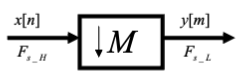

In [ ]:
f_start = 20e3
f_end = 25e3
fs = 100e3
num_samples = 16384

lfm_chirp_sig = sig_gen.cmplx_dt_lfm_chirp(1, f_start, f_end, fs, num_samples)
lfm_chirp_sig = lfm_chirp_sig.real + 1j*np.zeros(num_samples)
plot.spec_an(lfm_chirp_sig, fs, fft_shift=True, show_SFDR=False)
plt.show()

In [ ]:
M = 4
y_ds = multirate.decimate(lfm_chirp_sig, M)
plot.spec_an(y_ds, fs/M, fft_shift=True, show_SFDR=False)
plt.show()

### Upsampling

_Upsampling_ is the opposite of downsampling and is the process of _increasing_ the sample rate of a system. To upsample by an integer factor $L$, we can insert $L-1$ zeros between every sample from an input stream.

$$ y[n] = x[m]|_{m=n/L} $$

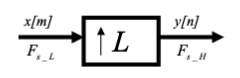

In [ ]:
f_start = -5e3
f_end = 5e3
fs = 100e3
num_samples = 16384

lfm_chirp_sig = sig_gen.cmplx_dt_lfm_chirp(1, f_start, f_end, fs, num_samples)
plot.spec_an(lfm_chirp_sig, fs, fft_shift=True, show_SFDR=False)
plt.show()

In [ ]:
L = 4
y_us = multirate.interpolate(lfm_chirp_sig, L)
plot.spec_an(y_us, fs*L, fft_shift=True, show_SFDR=False)
plt.show()

### Noble Identities

The _noble identity_ in multirate DSP allows us to commute resampling operations. Since down and upsamplers are Linear Time-Varying (LTV) processes, the order of operations matter- moving a $N$ downsampler through a filter $H(z)$ is equivalent to a filter $H(z^{N})$ followed by the $N$ downsampling operation. The primary use of this identity is to allow processing of multirate functions (e.x. filtering) at the ideal/efficient sample rate:

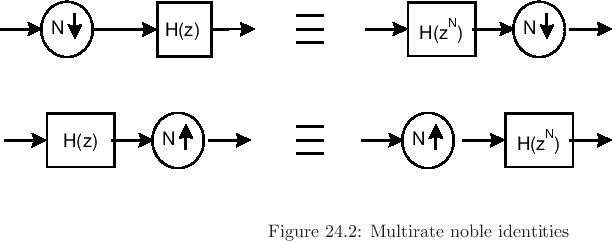

Memoryless operations (e.x. adders, multipliers) may be commuted across down and upsamplers as well:

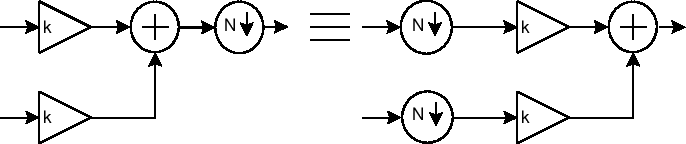

[From JOS](https://ccrma.stanford.edu/~jos/sasp/Multirate_Noble_Identities.html)

## Polyphase Filtering


### Polyphase Background & Operation

In multirate processing, an inefficient FIR filter is where processing is happening at a higher-than-necessary sample rate. For example, when low-pass filtering an input signal that is sampled at $4R$ rate, the naive implementation is to decimate (downsample) after the filtering operation to reduce to final sample rate $R$:
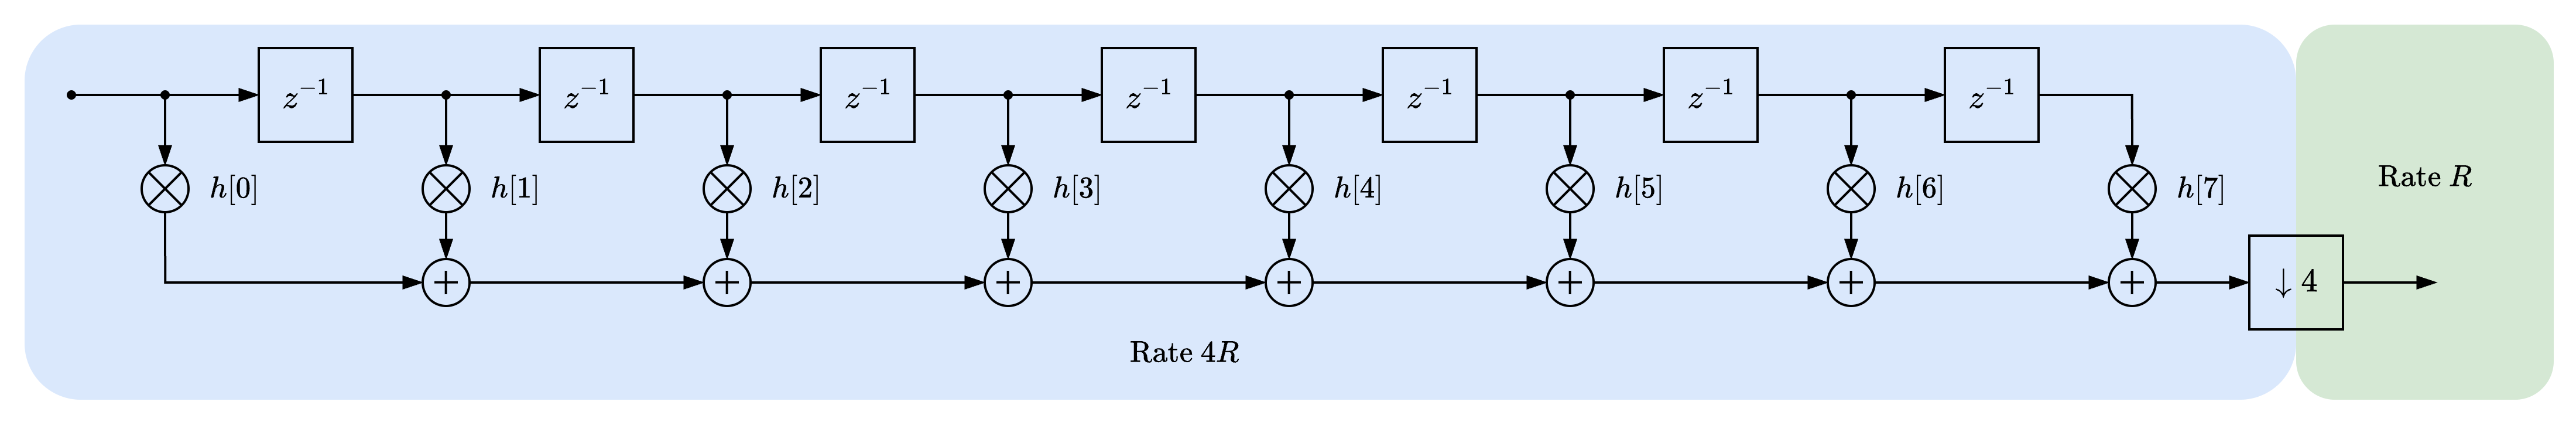

Given the noble identities above, we can not only change the order of downsampling to before the filtering operation, but we can break the filter into different legs that are commutated across the higher input sample rate:
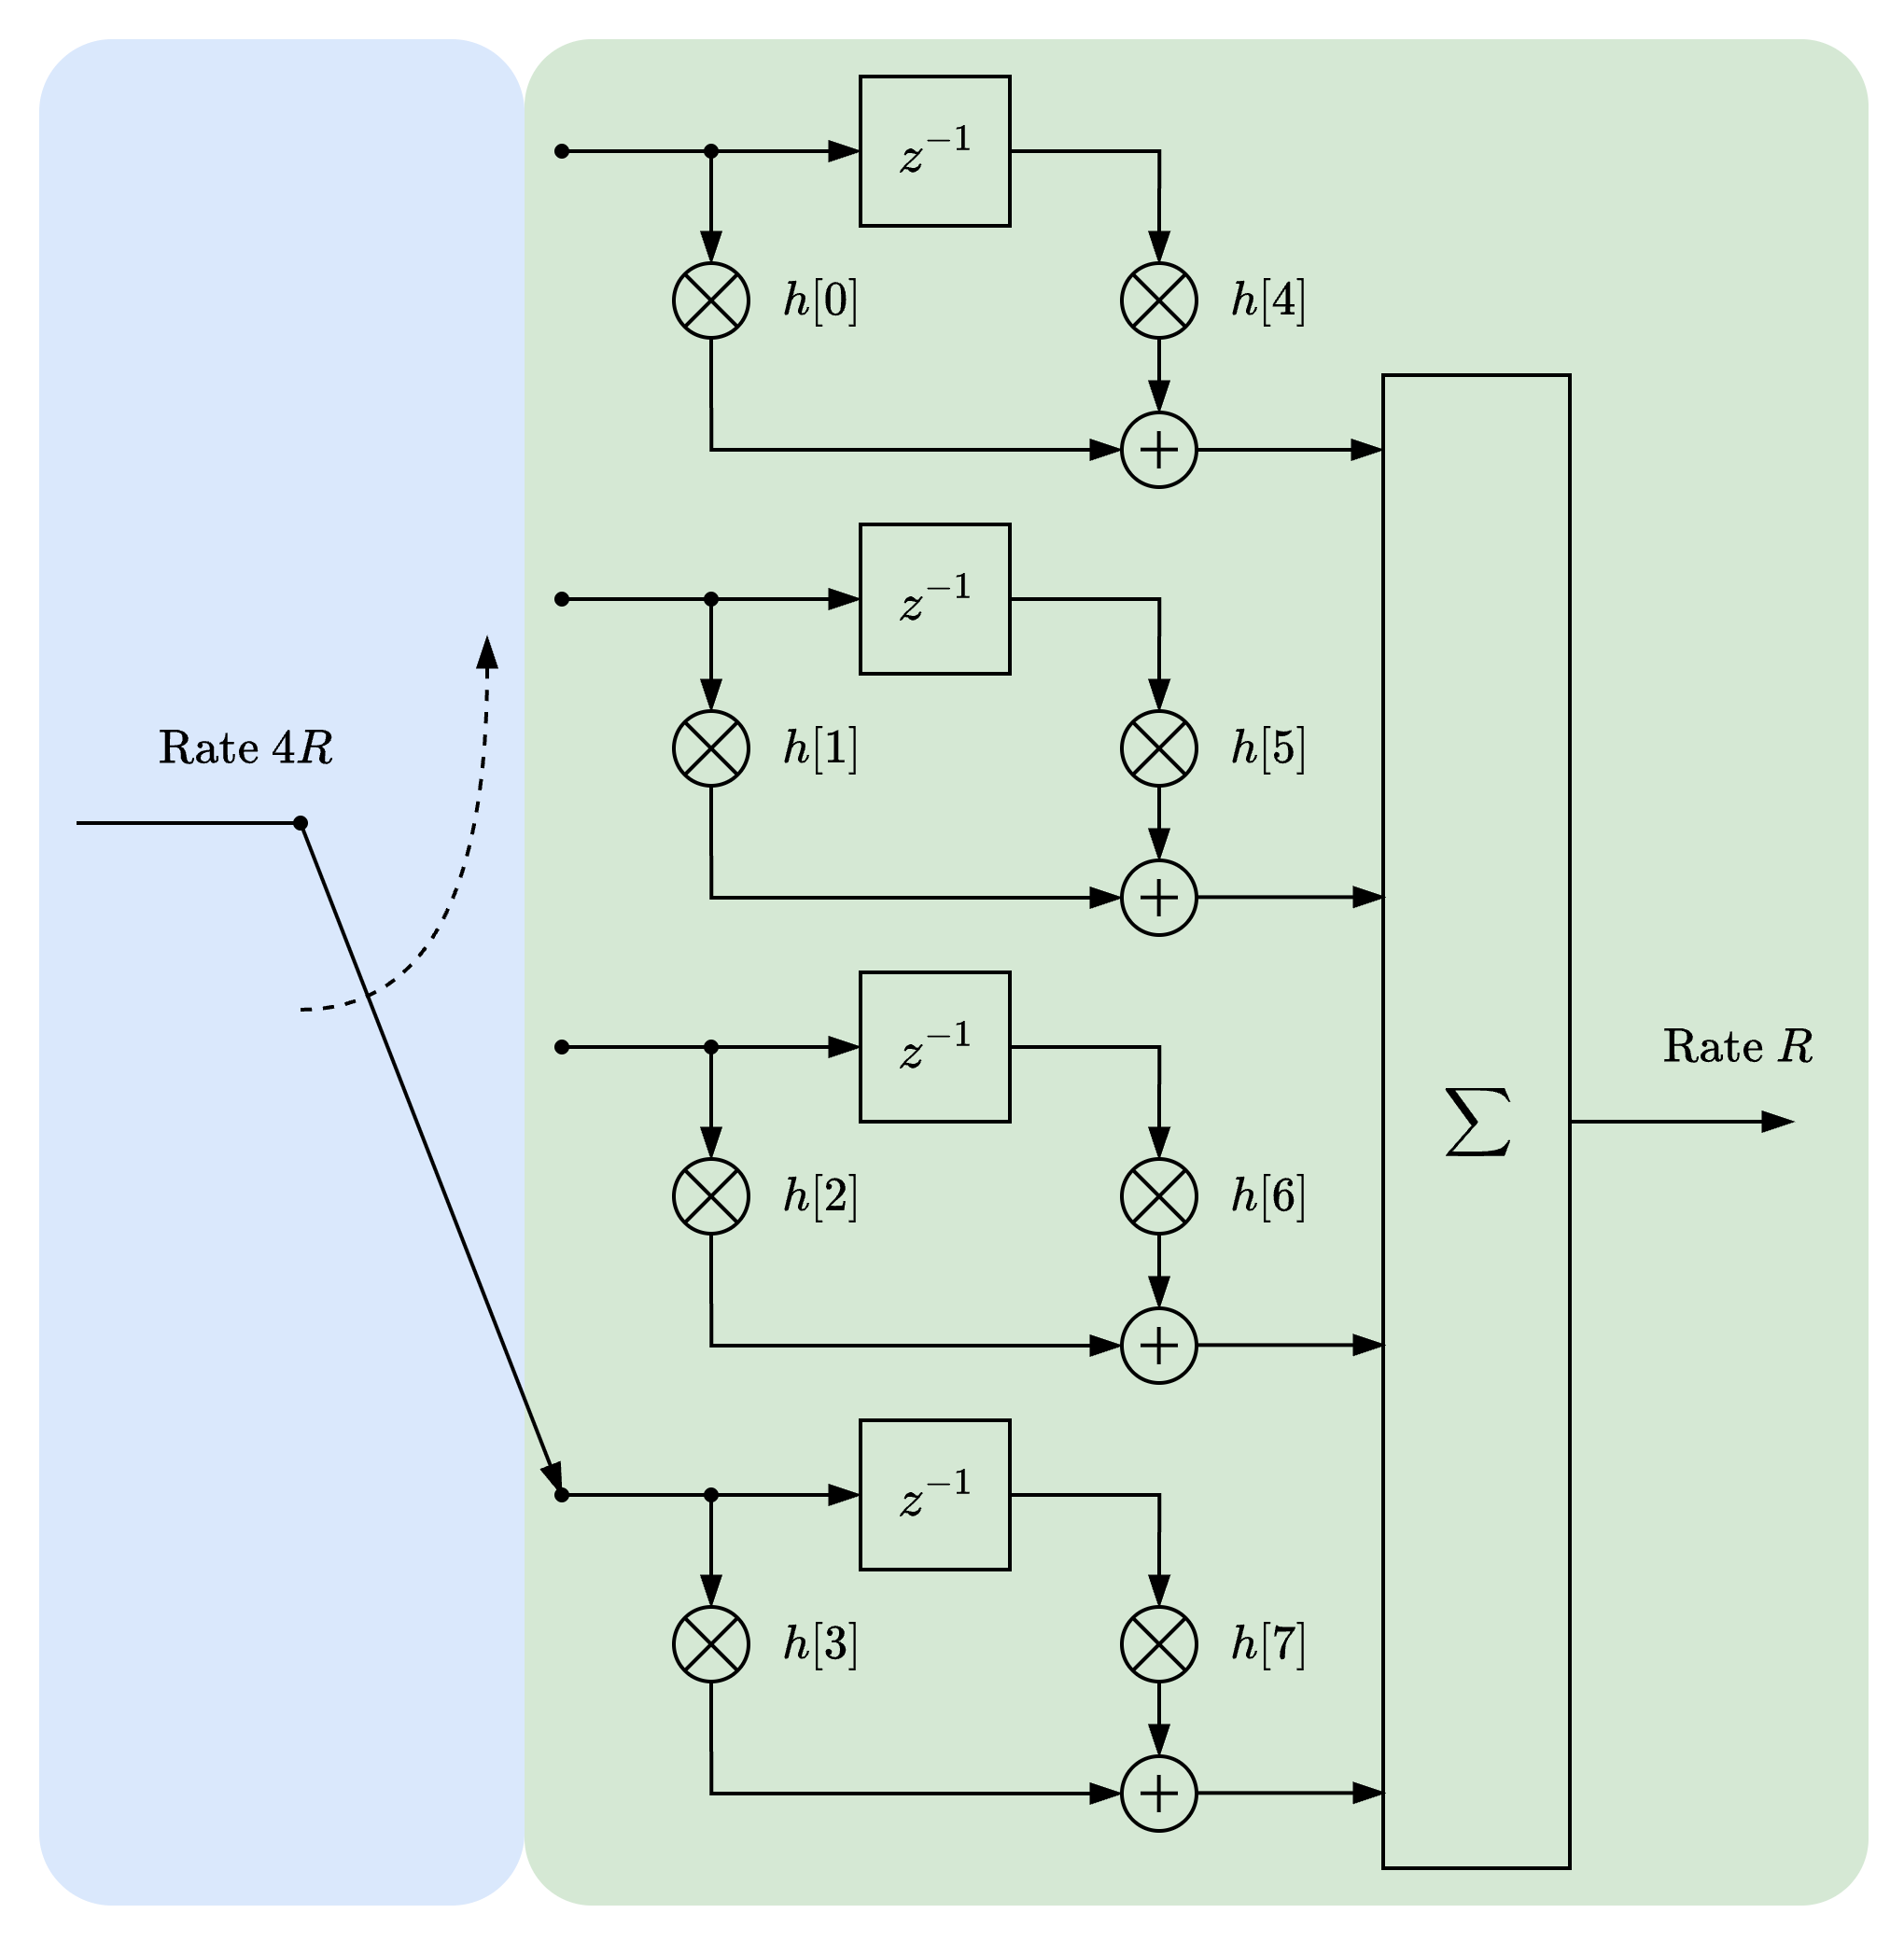

### Filter Design

Designing a polyphase filter starts with designing the _prototype filter_, which is used to specify the overall spectral performance desired. Since a polyphase filter is based on the FIR filter, we use the same filter design tools/methods- in this case the [minimax Remez exchange algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.remez.html).

In [ ]:
M = 5
N = 10 * M # Number of filter taps (number of taps per leg is N//M)
fs = 48e3 # sampling frequency (Hz)
w_delta = np.pi/20 # transition bandwidth
wp = ((np.pi/M) - w_delta)/np.pi # passband
ws = ((np.pi/M) + w_delta)/np.pi # stopband

# NOTE: vs MATLAB `firpm` which specifies band egdes from 0->fs, 
#  scipy.signal.remez() uses bands 0->fs/2
taps = signal.remez(N, [0, wp*fs/2, ws*fs/2, fs/2], [1, 0], fs=fs)
plot.filter_response(taps)
plot.plt.show()

pb_ripple, sb_atten = filter.measure_filter_response(taps, 0.0, wp, ws, 1.0)
print(f"Passband ripple: {pb_ripple:0.2f} dB | Stopband attenuation: {sb_atten:0.2f} dB")

The coefficients of the prototype FIR filter can then be assigned to each leg of the polyphase filter. Given $N$ taps in the prototype filter, a downsampling polyphase filter, decimating by $M$, would have $N/M$ taps per leg.

As an easy example, an $N=8$ tap filter of coefficients $h[0], h[1], h[2],...,h[7]$ would result in the following mapping for an $M=4$ polyphase filter:

$$ \boldsymbol{h} = \begin{bmatrix}
h[0] & h[4]\\
h[1] & h[5\\
h[2] & h[6]\\
h[3] & h[7]\\
\end{bmatrix} $$

Each row of the matrix is the coefficients for one polyphase filter leg.

In [ ]:
h_poly = taps.reshape(len(taps)//M, M).T

# generate x indices
xi = np.zeros_like(h_poly)
color = iter(cm.rainbow(np.linspace(0, 1, M)))
for i in range(M):
    xi[i] = list(range(i, N, M))
    plt.stem(xi[i], h_poly[i], cm.viridis(i/M), label=f"h[{i}]")

plt.legend()
plt.show()

It can be seen that the response of each polyphase leg is _allpass_ with _linear phase_ from $0 \rightarrow f_{s}$. And since [group delay is the negative first derative of phase response](https://www.mathworks.com/help/signal/ug/delay.html), or $\tau_{g}(\omega) = -\frac{d\theta(\omega)}{d\omega}$, it can be seen that each leg of a polyphase filter introduces a sub-sample (fraction) delay.

In [ ]:
fig, axs = plt.subplots(3, 1, layout='constrained')
for i in range(M):
    wi, hi = signal.freqz(h_poly[i])
    _, gd = signal.group_delay((h_poly[i], 1))
    axs[0].plot(wi / np.pi, utils.mag_to_dB(M * hi), linewidth=0.5, label=f"h[{i}]")
    axs[1].plot(wi / np.pi, np.unwrap(np.angle(hi)), linewidth=0.5, label=f"h[{i}]")
    axs[2].plot(wi / np.pi, gd, linewidth=0.5, label=f"h[{i}]")

axs[0].set_ylabel("Amplitude (dB)")
axs[0].margins(x=0)
axs[0].legend()
axs[1].set_ylabel("Angle (radians)")
axs[1].margins(x=0)
axs[1].legend()
axs[2].set_ylabel("Group delay (samples)")
axs[2].set_xlabel(r"Normalized Frequency ($\times \pi$ rad/sample)", fontsize=12)
axs[2].margins(x=0)
axs[2].legend()
nom_filt_delay = (N//M)/2
axs[2].set_ylim(nom_filt_delay - 1.1, nom_filt_delay + 0.1)
plt.show()

In [ ]:
f_start = 0
f_end = 0.1 * fs / 2.0
print(f"Passband from {f_start} -> {f_end} Hz")
num_samples = 100000

lfm_chirp_sig = np.real(sig_gen.cmplx_dt_lfm_chirp(1.0, f_start, f_end, fs, num_samples))
plot.spec_an(lfm_chirp_sig, fs, show_SFDR=False)
plot.plt.show()

In [ ]:
poly_filt_decim = multirate.polyphase_filter(M, taps * M, decimating=True)
poly_out = []
for x in lfm_chirp_sig:
    tmp_out, input_consumed = poly_filt_decim.step(x)
    if tmp_out is not None:
        poly_out.append(tmp_out)


plot.spec_an(poly_out, fs/M, show_SFDR=False)
plot.plt.show()

In [ ]:
plot.spec_an(multirate.interpolate(lfm_chirp_sig, M), fs*M, show_SFDR=False)
plot.plt.show()

In [ ]:
poly_filt_interp = multirate.polyphase_filter(M, taps, decimating=False)
poly_out = []
input_idx = 0
while input_idx < len(lfm_chirp_sig):
#for _ in range(24):
    tmp_out, input_consumed = poly_filt_interp.step(lfm_chirp_sig[input_idx])
    if tmp_out is not None:
        poly_out.append(tmp_out)
    if input_consumed:
        input_idx += 1

plot.spec_an(poly_out, fs*M, show_SFDR=False)
plot.plt.show()

### Polyphase Filter Banks (PFBs) and Channelizers

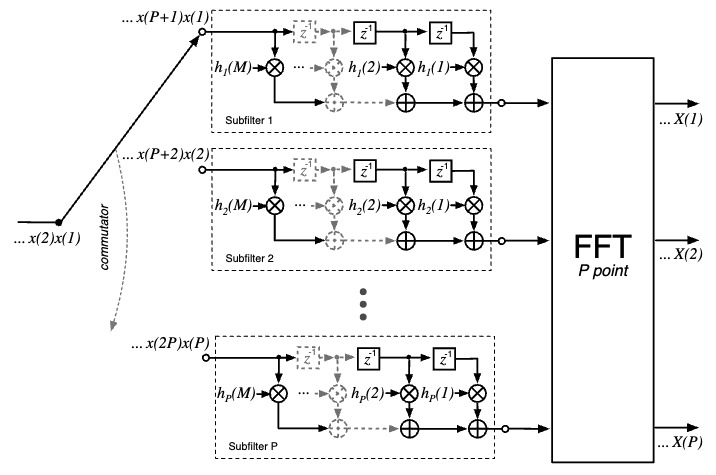

#### PFB References

* [Xilinx XAPP1161 Polyphase Filter Bank Channelizer, v1.0, Application Note](https://docs.amd.com/v/u/en-US/xapp1161)
* [Spectrometers and Polyphase Filterbanks in Radio Astronomy - Danny C. Price - arXiv](https://arxiv.org/pdf/1607.03579)
  + [Associated Jupyter Notebook](https://github.com/telegraphic/pfb_introduction/blob/master/pfb_introduction.ipynb)

In [ ]:
YouTubeVideo('WRO9VD6MYy4')

### Polyphase Filter References

* [Polyphase Filters - Section 12.4 Porat Notes](http://www.ws.binghamton.edu/fowler/fowler%20personal%20page/EE521_files/IV-05%20Polyphase%20FIlters%20Revised.pdf)
* [A Review of Polyphase Filter Banks and Their Application - DTIC AFRL](https://apps.dtic.mil/sti/tr/pdf/ADA457390.pdf)
* [VHDL whiz: Part 5 - Polyphase FIR Filters](https://vhdlwhiz.com/part-5-polyphase-fir-filters/)
* [Polyphase Filters and Filterbanks - Kyle](https://www.dsprelated.com/showarticle/191.php)
  + [polyphase-signal-processing.ipynb - Colaboratory](https://colab.research.google.com/github/kastnerkyle/kastnerkyle.github.io/blob/master/posts/polyphase-signal-processing/polyphase-signal-processing.ipynb)

In [ ]:
YouTubeVideo('Zmjk9NE-3k0')

In [ ]:
YouTubeVideo('afU9f5MuXr8')

## Cascaded Integrator–Comb (CIC) Filter

Benefits:
* Multiplier-free implementation for economical (light resource utilization) design in digital HW systems which can handle arbitrary, and large, rate changes.
* High interpolation CIC filters can push very narrowband signals (e.x. TT&C ~2MS/s max) go to sufficient ADC/DAC sample rates (e.x. 125MS/s)
* Data reduction to not have to pass as much data to/from the front end (e.g. having to push full sample bandwidth data to/from a remote radio head)

CIC filters can be used as decimation (decrease sample rate) and interpolation (increase sample rate) multirate filters:

<div style="text-align:center;">
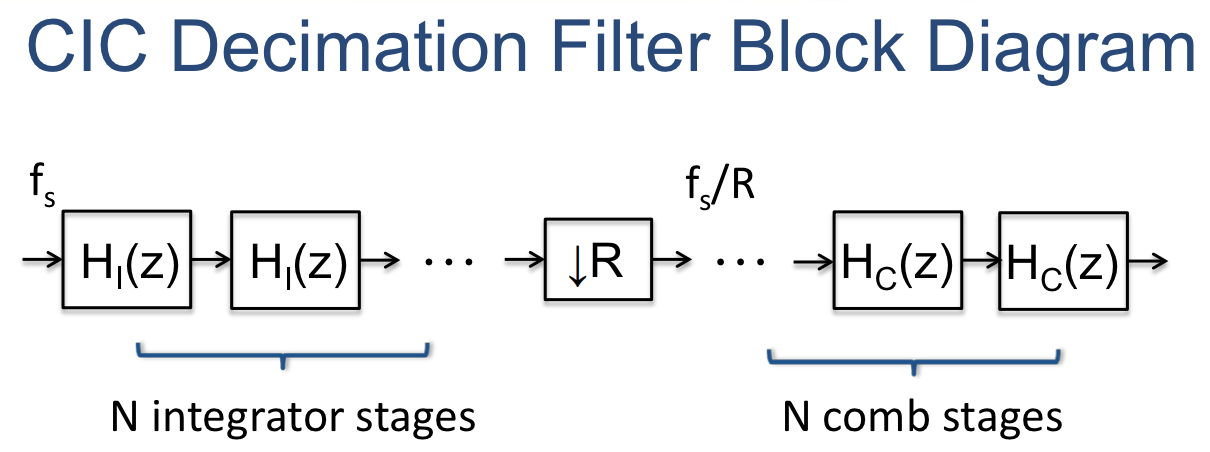
</div>

<div style="text-align:center;">
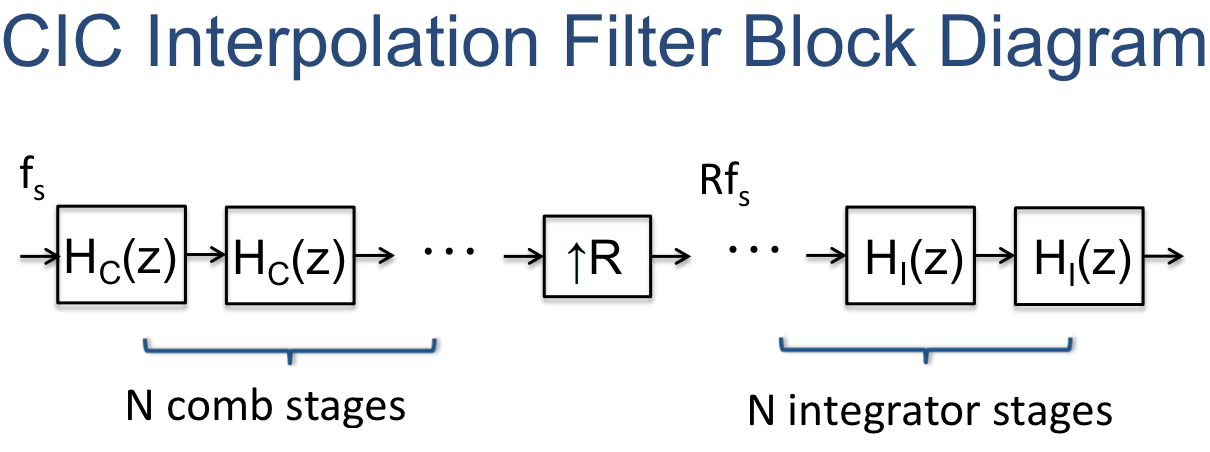
</div>

The basic building blocks are $N$ _integrator_ and $N$ _comb_ sections (hence the name), along with an interpolator (e.g. zero-stuffing expander) or decimator, increasing or decreasing the output sample rate by $R$ times (respectively).

### Integrator Section

An integrator is simply a single-pole IIR filter with unity feedback coefficient:
$$y[n] = y[n-1] + x[n]$$

This is also commonly known as an accumulator, which has the $z$-transform transfer function of:
$$H_{I}(z)=\frac{1}{1 - z^{-1}}$$

> The power response is basically a low-pass filter with a −20 dB per decade (−6 dB per
octave) rolloff, but with infinite gain at DC. This is due to the single pole at z = 1; the
output can grow without bound for a bounded input. In other words, a single integrator by
itself is unstable. - [CIC Filter Introduction - Matthew P. Donadio (DSP Guru)](http://dspguru.com/files/cic.pdf)

<div style="text-align:center;">
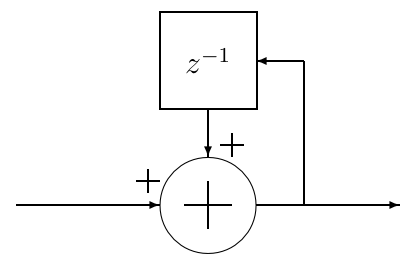
</div>

Note the pipelined version of the integrator which allows for more efficient digital hardware implementation (only one added between register stages):

<div style="text-align:center;">
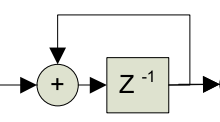
</div>

### Comb Section

The comb filter runs at the highest sample rate, $f_{C} = R*f_{I}$, in either decimation or interpolation filter form. It looks opposite of an integrator section as it subtracts the current sample value from a value $M$ sample periods prior; $M$ is the _differential delay_ design parameter, and is often limited to $M = 1$ or $M = 2$:
$$y[n] = x[n] - x[n - RM]$$

The corresponding transfer function at $f_{s}$ is:
$$H_{C}(z) = 1 - z^{-RM}$$

When $R=1$ and $M=1$, the power response is a high-pass function with 20dB per decade gain (inverse of the integrator response). When $RM \neq 1$, the power response looks like a familiar raised cosince form with $RM$ cycles from $0 \rightarrow 2\pi$.

<div style="text-align:center;">
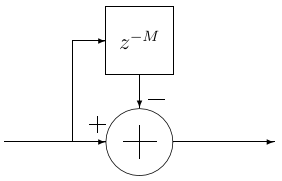
</div>

<div style="text-align:center;">
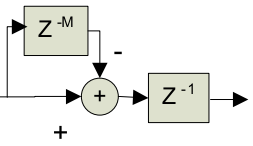
</div>

### Bit Growth

Due to the cascaded adders/subtracters in the CIC filter, each fixed-point, two's complement arithmetic operation requires an additional bit of output than input, to prevent loss of precision. Given an input sample bitwidth of $B_{in}$, the output bitwidth required can be found to be:
$$B_{out} = \lceil N\log_{2}RM + B_{in} \rceil$$

At the expense of [added quantization noise](https://www.dsprelated.com/showthread/comp.dsp/65321-1.php), bit growth can be controlled by rounding/scaling at some points within the CIC stages.

`#TODO:`
* [ ] Look at the fred harris paper on multiplier-less CIC with sharpening that doesn’t need compensation FIR
  + Also mentioned in https://www.dsprelated.com/showarticle/1337.php
* [ ] For bit growth, look at [CIC filter register pruning](https://www.dsprelated.com/showcode/269.php)
  + Also shown in http://www.jks.com/cic/cic.html and https://github.com/jks-prv/cic_prune

### Discrete-Time Test of CIC

In [ ]:
f_start = 0
f_end = 5e3
fs = 100e3
num_samples = 100000
bit_width = 16

lfm_chirp_sig = np.real(sig_gen.cmplx_dt_lfm_chirp(2**(bit_width-5), f_start, f_end, fs, num_samples))
freq, y_PSD = measurements.PSD(lfm_chirp_sig, fs, norm=True)
plot.freq_sig(freq, y_PSD, "LFM Chirp Input Spectrum", scale_noise=False)
plt.show()

In [ ]:
N = 3 # number of stages
R = 8 # interp/decim factor
M = 1 # differential delay in comb stages

cic_bit_width = 21 # np.ceil(N * np.log2(R*M) + bit_width)

integ_stages = [multirate.integrator(cic_bit_width) for i in range(N)]
comb_stages = [multirate.comb(M) for i in range(N)]

integ_out = np.zeros(len(lfm_chirp_sig))
for i in range(len(integ_out)):
    temp_val = int(lfm_chirp_sig[i])
    for j in range(N):
        temp_val = integ_stages[j].step(temp_val)
    integ_out[i] = temp_val

decimate_out = multirate.decimate(integ_out, R)

cic_out = np.zeros(len(decimate_out))
for i in range(len(cic_out)):
    temp_val = decimate_out[i]
    for j in range(N):
        temp_val = comb_stages[j].step(temp_val)
    cic_out[i] = temp_val

freq, y_PSD = measurements.PSD(cic_out, fs / R, norm=True)
plot.freq_sig(freq, y_PSD, "CIC Output Spectrum", scale_noise=False)
plt.show()

### CIC References
* [CIC Filter Introduction - Matthew P. Donadio (DSP Guru)](http://dspguru.com/files/cic.pdf)
  + * [CIC Filter Introduction - DSP Guru](http://dspguru.com/dsp/tutorials/cic-filter-introduction/)
* [A Beginner's Guide to Cascaded Integrator-Comb (CIC) Filters](https://www.dsprelated.com/showarticle/1337.php)
* [Small Tutorial on CIC Filters](http://www.tsdconseil.fr/log/scriptscilab/cic/cic-en.pdf)
* [CIC Filter - Wikipedia](https://en.wikipedia.org/wiki/Cascaded_integrator%E2%80%93comb_filter)
* [CIC Compiler v4.0 - Xilinx](https://docs.xilinx.com/v/u/en-US/pg140-cic-compiler)
* [CIC Filter - OpenCores](https://opencores.org/projects/cic_core)

## Fractional Delay Filtering

### Sub-Sample Time Delay with Polyphase Filters

Fractional delay tbd...

In [ ]:
M = 16384 # Number of sub-sample, fractional delay
U = 16 #27 # Number of filter taps per polyphase leg
N = U * M # Number of filter taps in prototype FIR

sinc_w = 3.99*N/8
x = np.linspace(-sinc_w, sinc_w, N)
taps = np.sinc(x)
# Reduce Gibbs Phenomenon (ringing) near Nyquist band edges (DC & fs)
# in all-pass response per leg by windowing filter weights
window = signal.windows.blackmanharris(N)
taps *= window
taps /= sum(taps)
plot.filter_response(taps)
plot.plt.show()

In [ ]:
h_poly = taps.reshape(U, M).T

h_poly = taps.reshape(U, M).T

In [ ]:
print(h_poly.shape)

In [ ]:
plt.figure()
plt.title('Digital filter group delay')
for i in range(10):
    w, gd = signal.group_delay((h_poly[i], 1))
    plt.plot(w/np.pi, gd, linewidth=0.5)
    
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
y_delt = 0.001
plt.ylim(U/2-y_delt,U/2+y_delt)
plt.show()

In [ ]:
plt.figure()
w, gd = signal.group_delay((h_poly[0], 1))
plt.plot(w/np.pi, gd)
w, gd = signal.group_delay((h_poly[M//2], 1))
plt.plot(w/np.pi, gd)
w, gd = signal.group_delay((h_poly[M-1], 1))
plt.plot(w/np.pi, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.show()

### Farrow Filter

* [ ] [Fractional Delay Farrow Filter - DSP Related](https://www.dsprelated.com/blogimages/JosefHoffmann/Farrow_Filter.pdf)
* [ ] [Polyphase filter / Farrows interpolation - DSP Related](https://www.dsprelated.com/showarticle/22.php)
* [ ] [Fractional Delay Farrow Filter AI Engine - AMD-Xilinx](https://github.com/Xilinx/Vitis-Tutorials/tree/2024.2/AI_Engine_Development/AIE/Design_Tutorials/15-farrow_filter)